# YIELD CURVE: Forecasting a Recession

A deeper dive into [U.S. Department of the Treasury](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield) Yield Curve data and it's predictive capaiblities. 

In an efficiently performing market, long-term bonds have higher bond yield rates than shorter-term bonds, T-notes, and T-bills as the market expects greater risk in investing in long-term bonds (a lot can happen in 30 years). However, when the yield curve inverts, the bond yield rates for shorter-term bonds are higher than long-term bond yield rates. An Inverted Yield Curve is used as one predictor of a recession as it captures the nervousness of investors about the near term market outlook.

In my analysis below, an Inverted Yield Curve occurs when the ratio of long-term bond rates (i.e. 30 years, 10 years) versus short-term bonds(6 months, 1 year, 10 years) is between 0 and 1. The yield curve last inverted between 2006 and 2007. 

In [3]:
%matplotlib inline
import requests
import xml.etree.ElementTree as et
from xml.parsers.expat import ExpatError
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import urllib.request as urllib2

## Retrieving and Organizing the Data

The following code demonstrates scraping the Treasury website and organizing the data into a Pandas dataframe.

In [4]:
#---- Scrape XML From Treasury Website ----#
year  = 2020
curpath = os.path.dirname(os.path.realpath("./yield"))
data_dir = data_dir = curpath + '/data/xml'
while (year <=2020):
    filename = os.path.join(data_dir, '%s.xml' %year )
    resp = urllib2.urlopen('http://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20'+ str(year))
    xml = resp.read()
    with open(filename, "wb") as file:
        file.write(xml)
        print("Pulled file: %s" % filename)    
    year += 1

Pulled file: /opt/yield/data/xml/2020.xml


In [5]:
#-------- Retrieve XML Files --------#
# Current  directory:
curpath = os.path.dirname( os.path.abspath("./yield/"))

# Traverse a directory
data_dir = curpath + '/data/'
def traverse_directory(directory):
    files = [directory+f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files

In [6]:
# ----Prepend Namespaces for Retrieval ----#
def prepend_atom(s):
    return '{http://www.w3.org/2005/Atom}' + s

def prepend_schema(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}%s' % s

def prepend_ds(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices}%s' % s

In [7]:
# ----Build a Dictionary of All Entries from 1990 to Present  ----#
def build_entries_dict(count, dentries, root):
    for elem in root.findall(prepend_atom('entry')):
        count +=1
        dentry = {}
        properties = elem.find(prepend_atom('content')).find(prepend_schema('properties'))
        iid = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('Id')).text
        date = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('NEW_DATE')).text
        bc_1month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1MONTH')).text
        bc_3month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3MONTH')).text
        bc_6month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_6MONTH')).text
        bc_1yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1YEAR')).text
        bc_2yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_2YEAR')).text
        bc_3yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3YEAR')).text
        bc_5yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_5YEAR')).text
        bc_7yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_7YEAR')).text
        bc_10yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_10YEAR')).text
        bc_30yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEAR')).text
        bc_30yr_display = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEARDISPLAY')).text
        dentry['date'] = date
        dentry['1m'] = bc_1month
        dentry['3m'] = bc_3month
        dentry['6m'] = bc_6month
        dentry['1y'] = bc_1yr
        dentry['2y'] = bc_2yr
        dentry['3y'] = bc_3yr
        dentry['5y'] = bc_5yr
        dentry['7y'] = bc_7yr
        dentry['10y'] = bc_10yr
        dentry['30y'] = bc_30yr
        dentries[iid] = dentry
    return dentries

In [8]:
# ---- Parse the XML to create a Dict of All Data ---#
def parse_xml(filename, count, dentries):
    try:
        #Parse the given XML file:
        tree = et.parse(filename)
    except ExpatError as e:
        print ("[XML] Error (line %d): %d" % (e.lineno, e.code))
        print ("[XML] Offset: %d" % (e.offset))
        raise e
    except IOError as e:
        print ("[XML] I/O Error %d: %s" % (e.errno, e.strerror))
        raise e
    else:
        root = tree.getroot()
        dentries = build_entries_dict(count, dentries, root)
    return dentries

In [9]:
#-------- Main --------#
count = 0
dentries = {}
curpath = os.path.dirname( os.path.abspath("./yield/"))
data_dir = curpath + '/data/xml/'
xml_files = traverse_directory(data_dir)
for f in xml_files:
    dentries = parse_xml(f, count, dentries)

In [18]:
# ---- Load JSON Into Pandas DataFrame ----#
# Convert dict to JSON
json_entries = json.dumps(dentries)
# Create a Panda Dataframe
df = pd.read_json(json_entries, convert_dates=True, convert_axes=True, orient='index')
df = df[['date','1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '30y']]
df['10y/3m'] = df['10y']/df['3m']
df['10y/6m'] = df['10y']/df['6m']
df['10y/1y'] = df['10y']/df['1y']
df['10y/2y'] = df['10y']/df['2y']
df['10y/3y'] = df['10y']/df['3y']
df['10y/5y'] = df['10y']/df['5y']
df['10y/7y'] = df['10y']/df['7y']
df['30y/10y'] = df['30y']/df['10y']
df.head()

date  1m    3m    6m    1y    2y    3y    5y    7y   10y   30y  \
1    1997-01-02 NaN  5.19  5.35  5.63  5.97  6.13  6.30  6.45  6.54  6.75   
10   1996-12-27 NaN  5.11  5.28  5.47  5.81  5.93  6.09  6.21  6.30  6.54   
100  1996-09-11 NaN  5.31  5.52  5.94  6.34  6.51  6.70  6.84  6.94  7.12   
1000 1998-05-14 NaN  5.18  5.38  5.48  5.63  5.64  5.66  5.76  5.67  5.98   
1001 1998-05-13 NaN  5.12  5.38  5.44  5.59  5.60  5.63  5.72  5.64  5.95   

        10y/3m    10y/6m    10y/1y    10y/2y    10y/3y    10y/5y    10y/7y  \
1     1.260116  1.222430  1.161634  1.095477  1.066884  1.038095  1.013954   
10    1.232877  1.193182  1.151737  1.084337  1.062395  1.034483  1.014493   
100   1.306968  1.257246  1.168350  1.094637  1.066052  1.035821  1.014620   
1000  1.094595  1.053903  1.034672  1.007105  1.005319  1.001767  0.984375   
1001  1.101562  1.048327  1.036765  1.008944  1.007143  1.001776  0.986014   

       30y/10y  
1     1.032110  
10    1.038095  
100   1.025937  
1000  1.054674  
1001  1.054965

In [19]:
df.describe() # descriptive statistics

1m           3m           6m           1y           2y  \
count  4508.000000  7404.000000  7407.000000  7407.000000  7407.000000   
mean      1.282846     2.790432     2.924250     3.054581     3.364365   
std       1.498316     2.297390     2.329689     2.325180     2.337877   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.060000     0.280000     0.450000     0.600000     0.980000   
50%       0.870000     2.450000     2.540000     2.720000     3.220000   
75%       1.930000     5.030000     5.140000     5.190000     5.455000   
max       5.270000     8.260000     8.490000     8.640000     9.050000   

                3y           5y           7y          10y          30y  \
count  7407.000000  7407.000000  7407.000000  7407.000000  6413.000000   
mean      3.587239     3.991597     4.302600     4.543169     5.098486   
std       2.278098     2.144098     2.040394     1.918257     1.838420   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.420000     1.940000     2.350000     2.770000     3.210000   
50%       3.620000     3.980000     4.230000     4.460000     4.920000   
75%       5.580000     5.790000     5.990000     6.000000     6.580000   
max       9.110000     9.100000     9.120000     9.090000     9.180000   

            10y/3m       10y/6m       10y/1y       10y/2y       10y/3y  \
count  7403.000000  7406.000000  7406.000000  7406.000000  7406.000000   
mean           inf     7.150245     4.334767     2.349766     1.768719   
std            NaN    12.198079     5.807370     2.033336     1.112028   
min       0.825000     0.850515     0.902834     0.918495     0.925750   
25%       1.185375     1.148569     1.122103     1.075814     1.062073   
50%       1.835443     1.722557     1.613389     1.392131     1.282601   
75%       6.542051     4.322188     3.419061     2.521304     1.981308   
max            inf   146.000000    29.555556    12.315789     7.000000   

            10y/5y       10y/7y      30y/10y  
count  7406.000000  7406.000000  6412.000000  
mean      1.277830     1.097697     1.175404  
std       0.358423     0.125635     0.179040  
min       0.947798     0.949126     0.943854  
25%       1.036924     1.013370     1.037552  
50%       1.128795     1.052632     1.094660  
75%       1.390244     1.139130     1.290179  
max       2.698413     1.607843     1.737500

In [38]:
df['3m'].describe() # descriptive statistics for one column

count    7404.000000
mean        2.790432
std         2.297390
min         0.000000
25%         0.280000
50%         2.450000
75%         5.030000
max         8.260000
Name: 3m, dtype: float64

In [39]:
df['date'].describe() # descriptive statistics for categorical data

count                    7408
unique                   7408
top       2017-05-11 00:00:00
freq                        1
first     1990-01-02 00:00:00
last      2020-01-30 00:00:00
Name: date, dtype: object

In [40]:
true_copy_df = df.copy() # deep copy the data frame instaead of just referencing
len(true_copy_df.index) 

7408

In [41]:
true_copy_df[['date', '10y/3m']]

date    10y/3m
1    1997-01-02  1.260116
10   1996-12-27  1.232877
100  1996-09-11  1.306968
1000 1998-05-14  1.094595
1001 1998-05-13  1.101562
...         ...       ...
995  1998-04-23  1.117878
996  1998-04-22  1.115913
997  1998-05-11  1.126459
998  1998-05-08  1.110895
999  1998-05-12  1.113281

[7408 rows x 2 columns]

In [42]:
true_copy_df = true_copy_df[true_copy_df['10y/3m'] < 1]
len(true_copy_df.index) 

447

In [43]:
true_copy_df.sort_values('date', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

date    1m    3m    6m    1y    2y    3y    5y    7y   10y   30y  \
7412 2019-08-13  2.05  2.00  1.96  1.86  1.66  1.60  1.57  1.62  1.68  2.15   
7411 2019-08-12  2.09  2.00  1.94  1.75  1.58  1.51  1.49  1.56  1.65  2.14   
7410 2019-08-09  2.05  2.00  1.95  1.78  1.63  1.58  1.57  1.65  1.74  2.26   
7409 2019-08-08  2.09  2.02  1.96  1.79  1.62  1.54  1.54  1.62  1.72  2.25   
7408 2019-08-07  2.02  2.02  1.95  1.75  1.59  1.51  1.52  1.60  1.71  2.22   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1305 1998-10-05   NaN  4.23  4.34  4.18  4.04  4.02  3.95  4.13  4.16  4.70   
1297 1998-09-22   NaN  4.81  4.87  4.72  4.66  4.62  4.57  4.69  4.73  5.16   
1295 1998-09-21   NaN  4.82  4.86  4.71  4.63  4.58  4.51  4.64  4.69  5.12   
1301 1998-09-11   NaN  4.87  4.88  4.73  4.68  4.65  4.65  4.81  4.85  5.23   
1246 1998-09-10   NaN  4.78  4.76  4.60  4.57  4.51  4.55  4.72  4.76  5.18   

        10y/3m    10y/6m    10y/1y    10y/2y    10y/3y    10y/5y    10y/7y  \
7412  0.840000  0.857143  0.903226  1.012048  1.050000  1.070064  1.037037   
7411  0.825000  0.850515  0.942857  1.044304  1.092715  1.107383  1.057692   
7410  0.870000  0.892308  0.977528  1.067485  1.101266  1.108280  1.054545   
7409  0.851485  0.877551  0.960894  1.061728  1.116883  1.116883  1.061728   
7408  0.846535  0.876923  0.977143  1.075472  1.132450  1.125000  1.068750   
...        ...       ...       ...       ...       ...       ...       ...   
1305  0.983451  0.958525  0.995215  1.029703  1.034826  1.053165  1.007264   
1297  0.983368  0.971253  1.002119  1.015021  1.023810  1.035011  1.008529   
1295  0.973029  0.965021  0.995754  1.012959  1.024017  1.039911  1.010776   
1301  0.995893  0.993852  1.025370  1.036325  1.043011  1.043011  1.008316   
1246  0.995816  1.000000  1.034783  1.041576  1.055432  1.046154  1.008475   

       30y/10y  
7412  1.279762  
7411  1.296970  
7410  1.298851  
7409  1.308140  
7408  1.298246  
...        ...  
1305  1.129808  
1297  1.090909  
1295  1.091684  
1301  1.078351  
1246  1.088235  

[447 rows x 19 columns]

## Visualizing the Data

In [44]:
# ---- Visualize Data ----#
# Global Plot Configs
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (60,22)
plt.rcParams.update({'font.size': 33})

### Bond Yield Rate Ratio For Years 1990 to Present

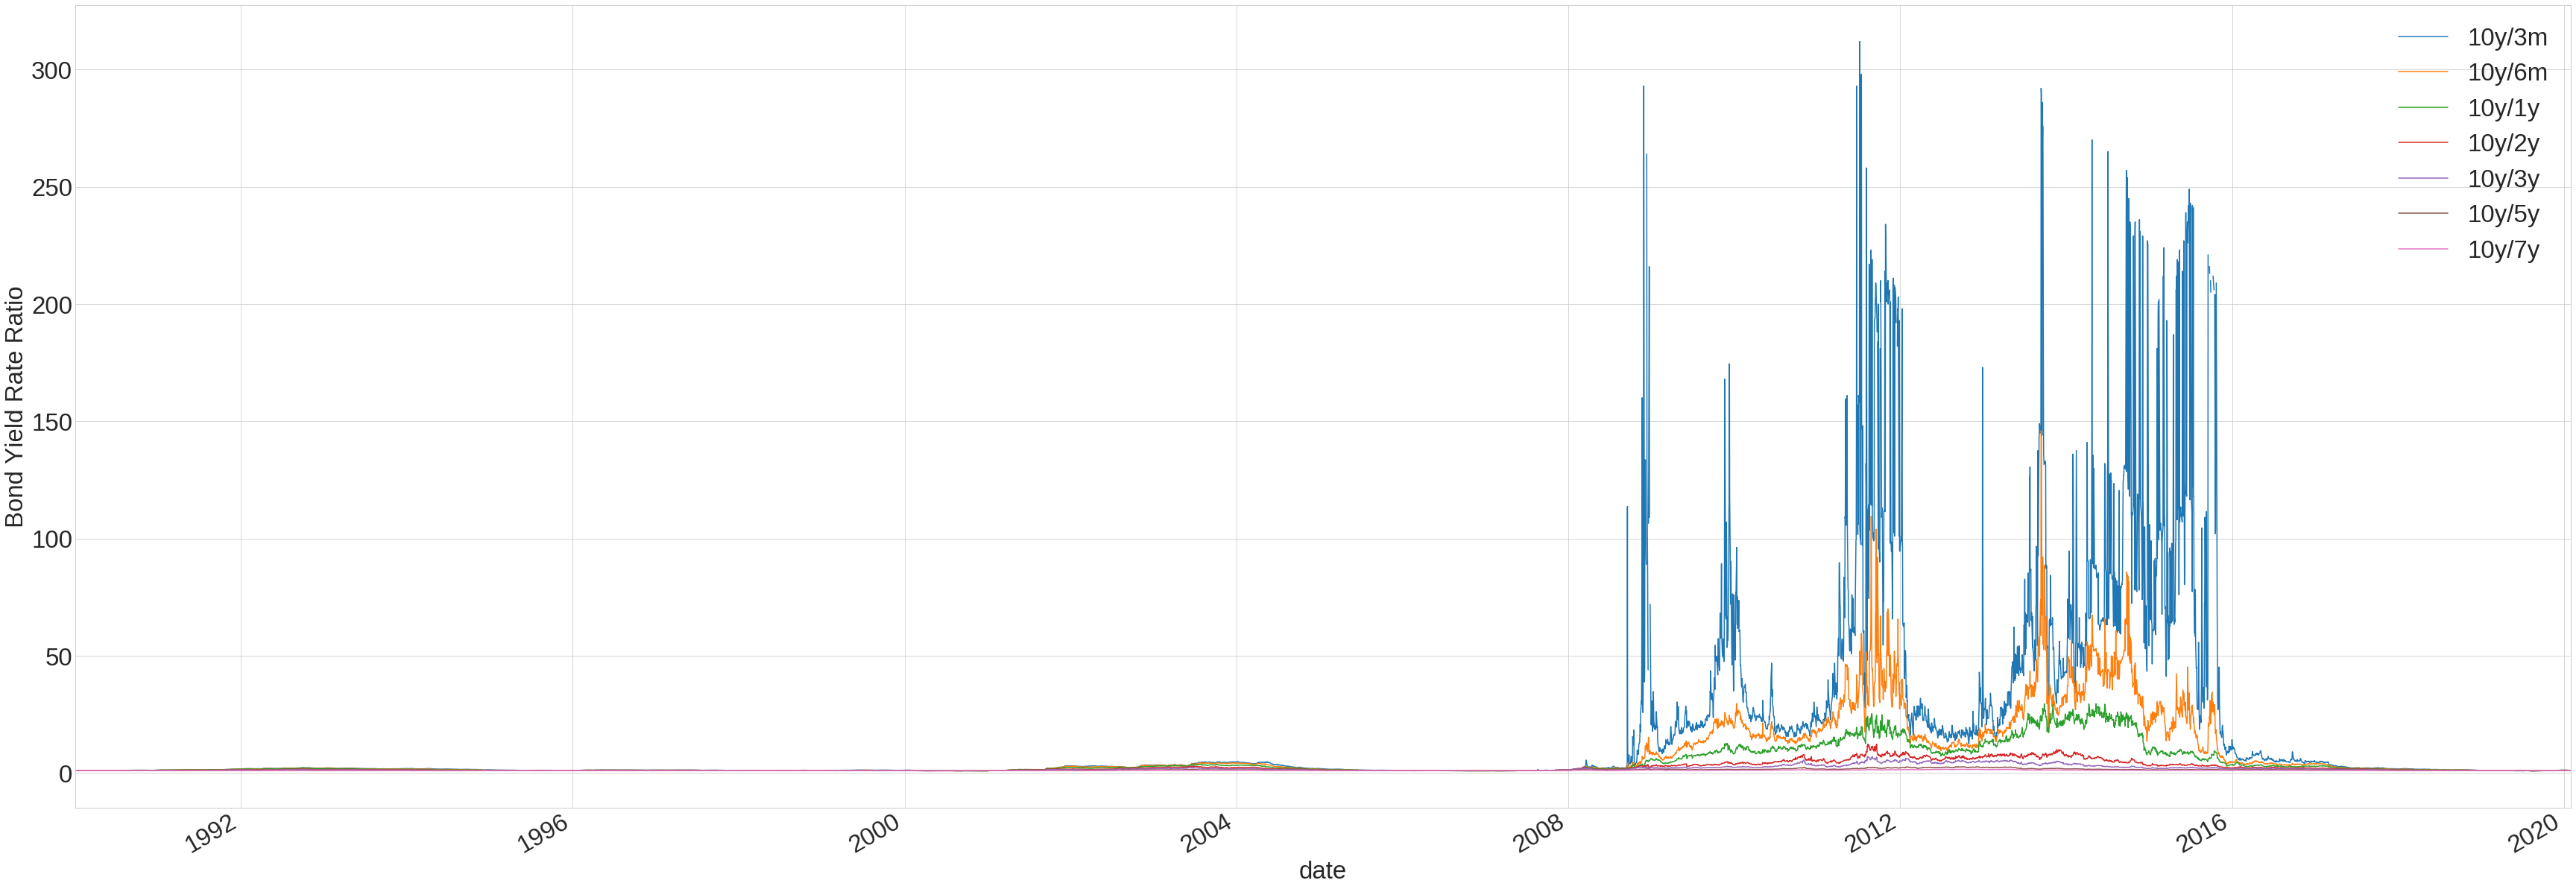

In [45]:
ax = plt.gca() #get current axes
plt.ylabel('Bond Yield Rate Ratio')
df.plot(kind='line', x='date', y='10y/3m', ax=ax)
df.plot(kind='line', x='date', y='10y/6m', ax=ax)
df.plot(kind='line', x='date', y='10y/1y', ax=ax)
df.plot(kind='line', x='date', y='10y/2y', ax=ax)
df.plot(kind='line', x='date', y='10y/3y', ax=ax)
df.plot(kind='line', x='date', y='10y/5y', ax=ax)
df.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratio for Years 2006 to Present

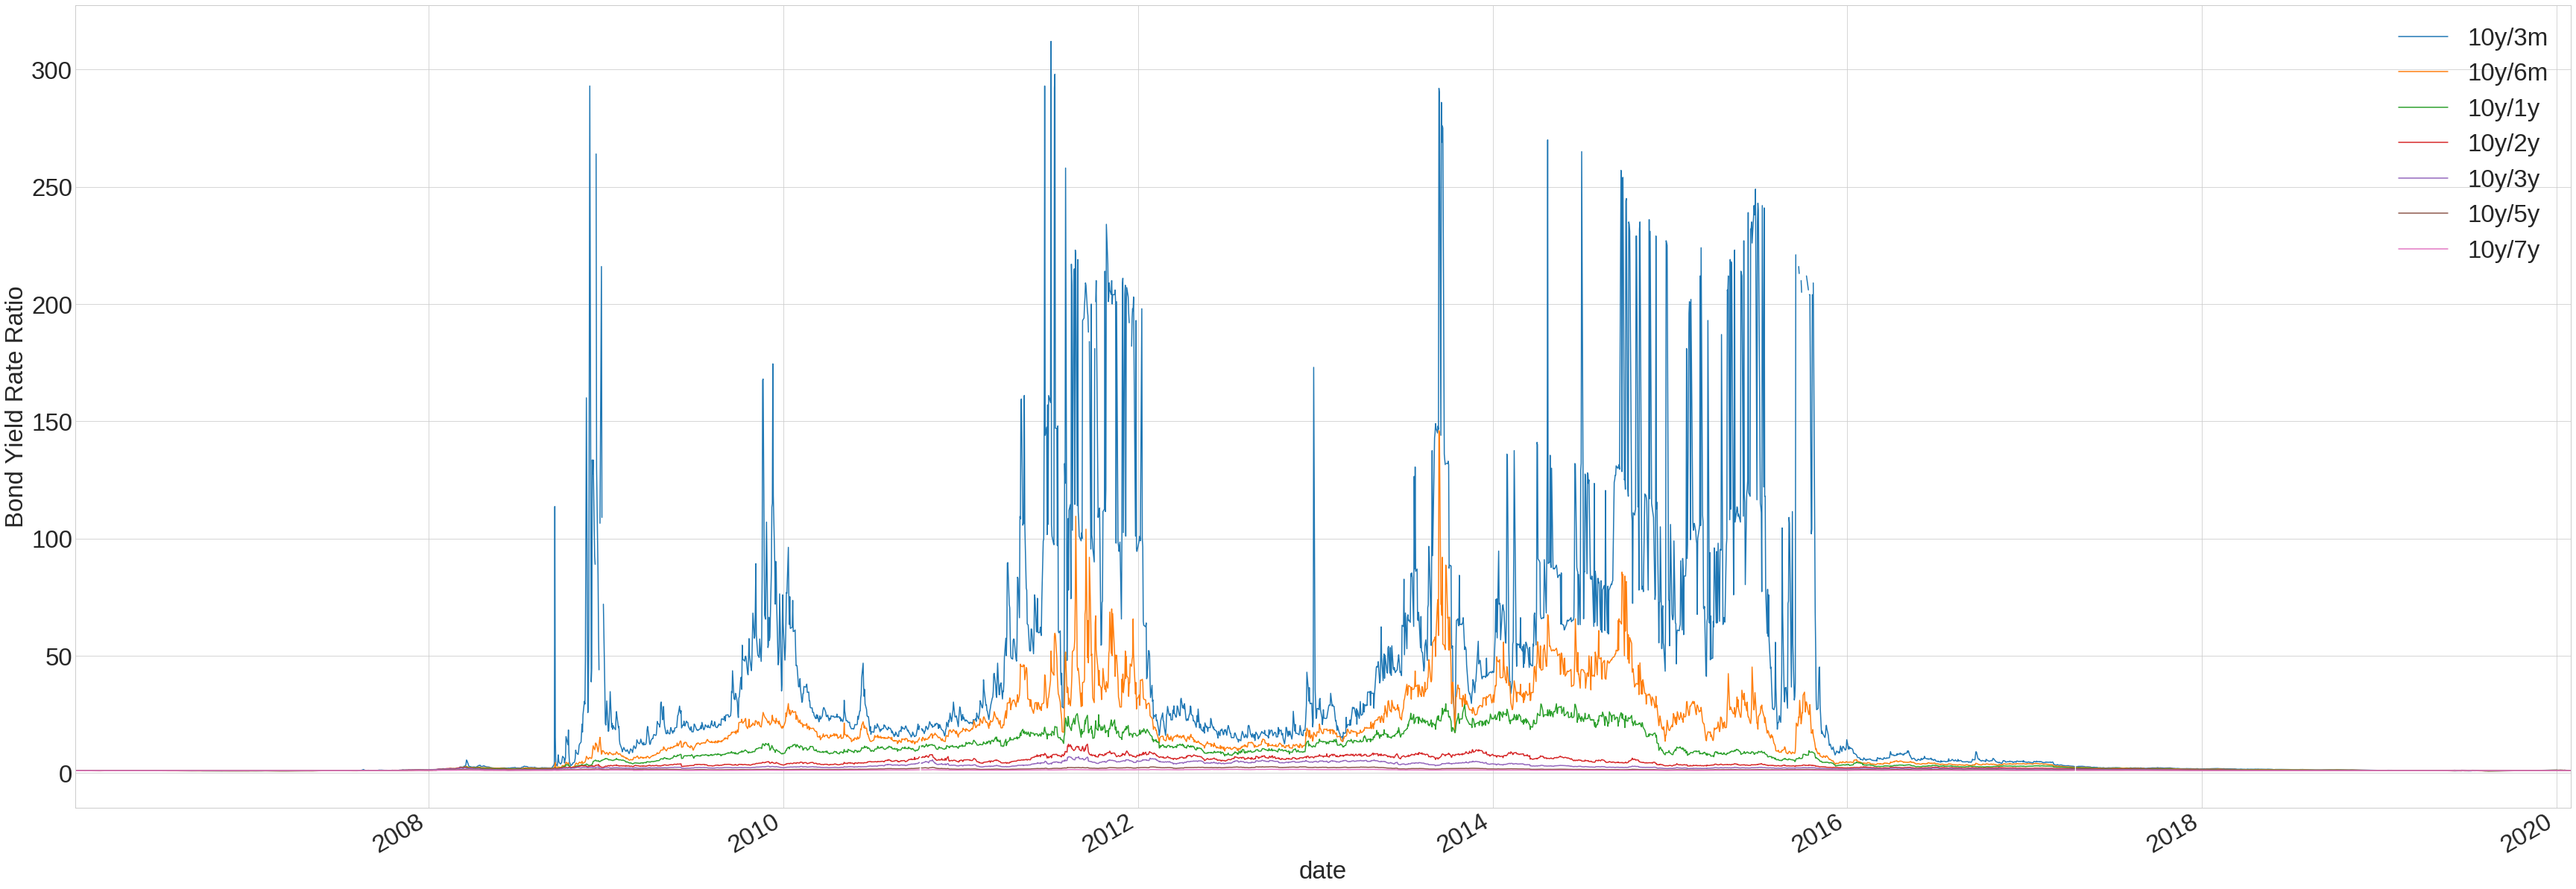

In [46]:
df_lim = df
df_lim = df_lim.loc[df_lim['date']>='2006-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratio for Years 2016 to 2018
 

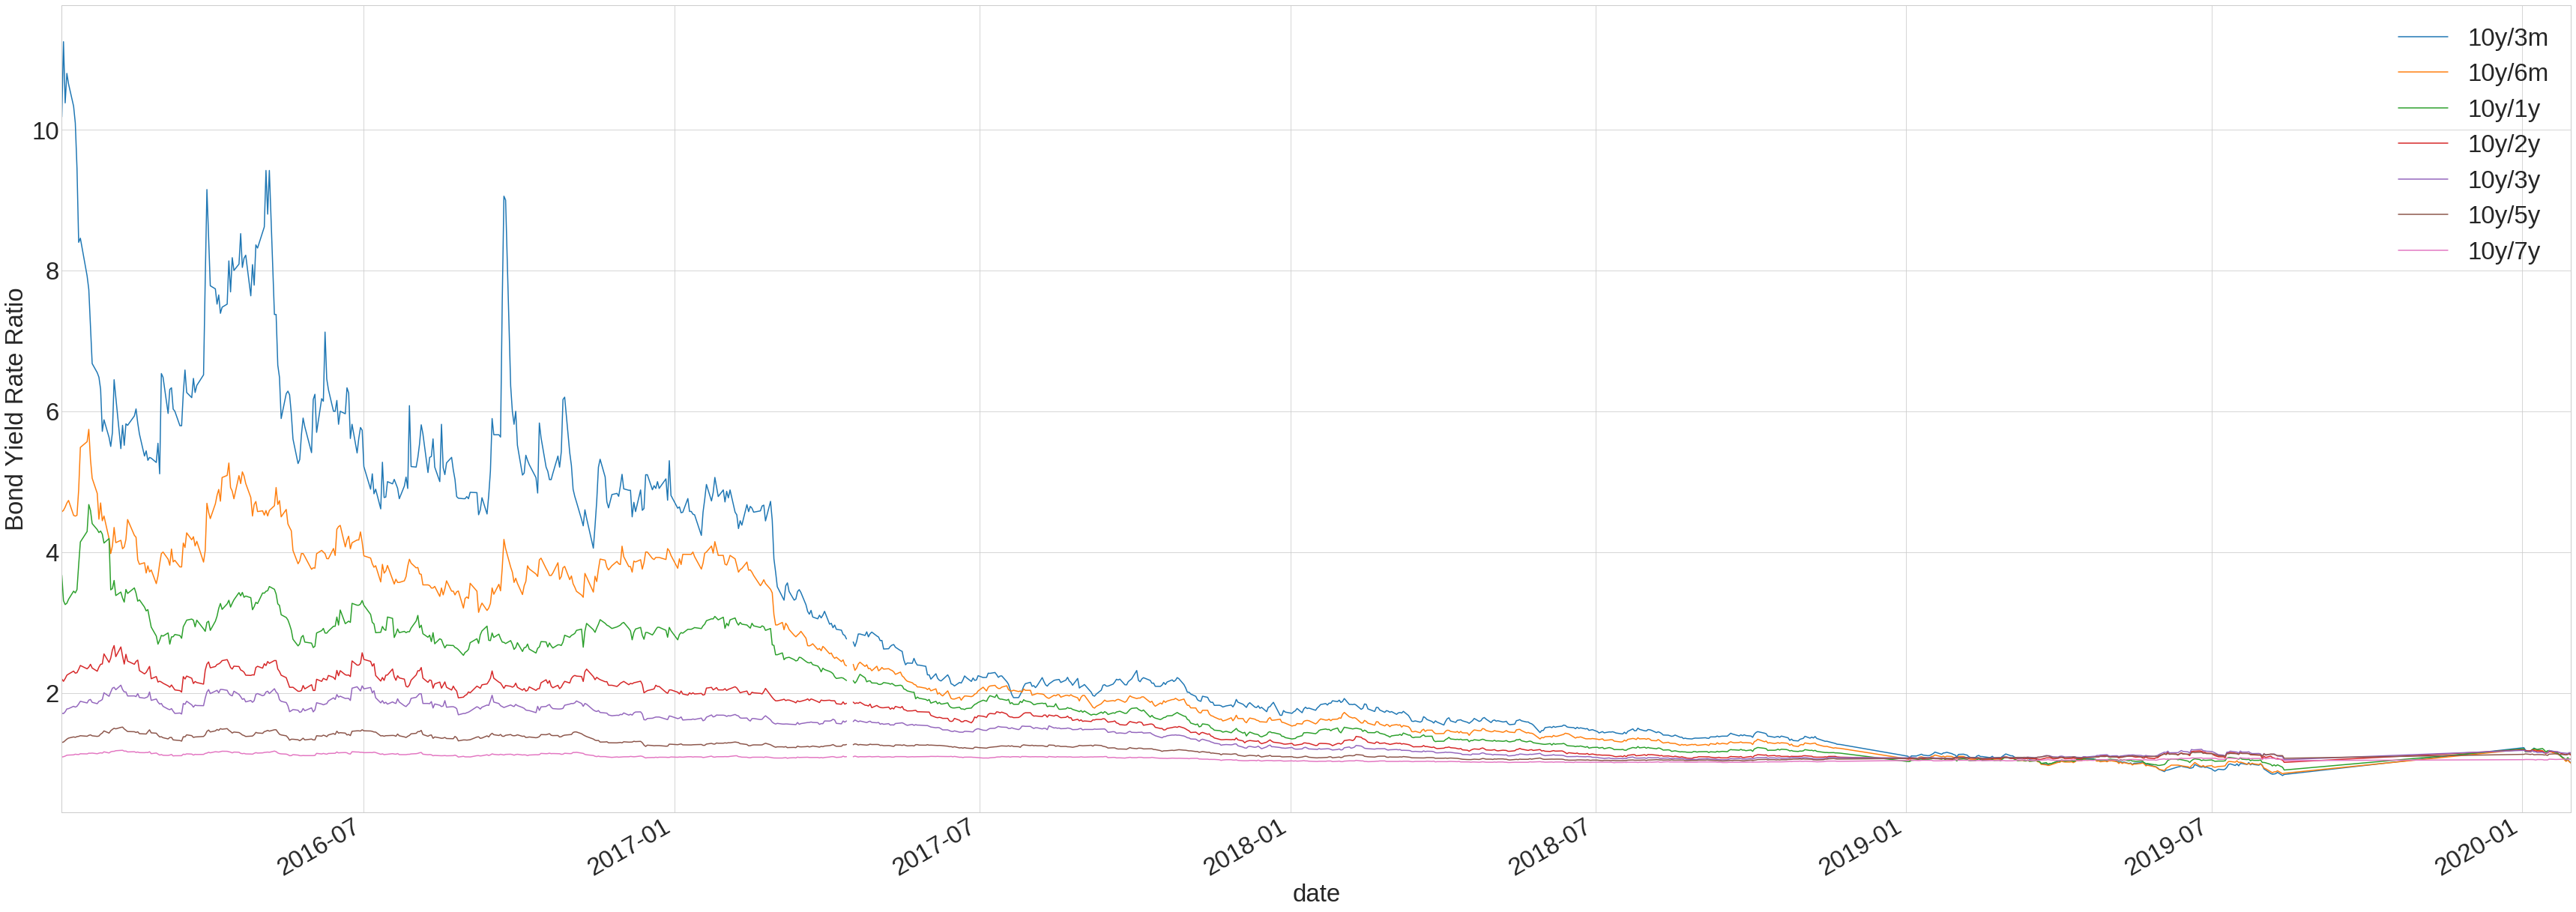

In [47]:
df_lim_16 = df
df_lim_16 = df_lim.loc[df_lim['date']>='2016-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_16.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratio for Years 2006 to 2007
Interestingly, the yield curve inverted during this period.

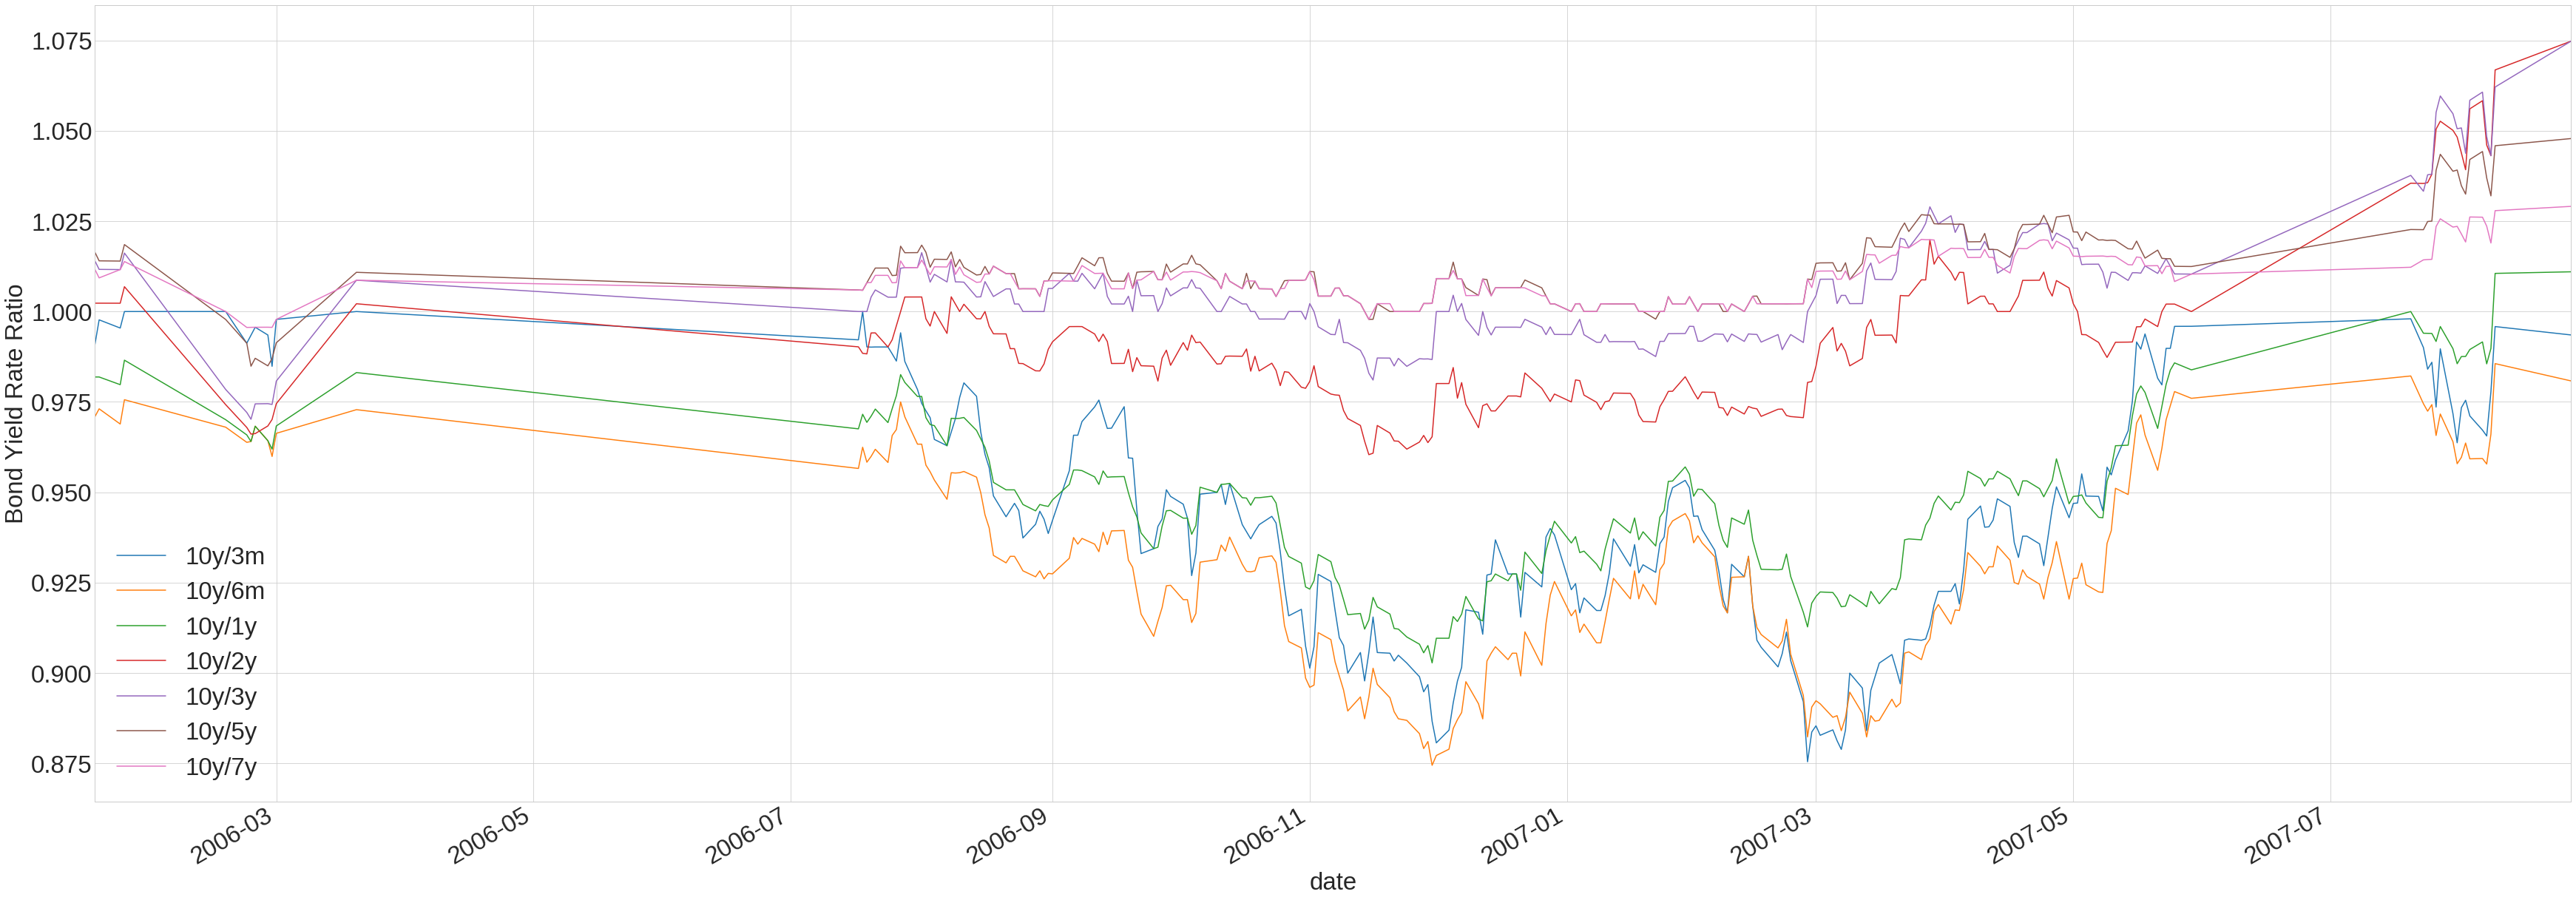

In [52]:
df_lim = df
df_lim = df_lim.loc[(df_lim['date']>='2006-01-01') & (df_lim['date']<='2009-01-01') & (df_lim['10y/3m']<=1) ]
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratio Comparing 10 Year Bonds to 6 month T-Notes

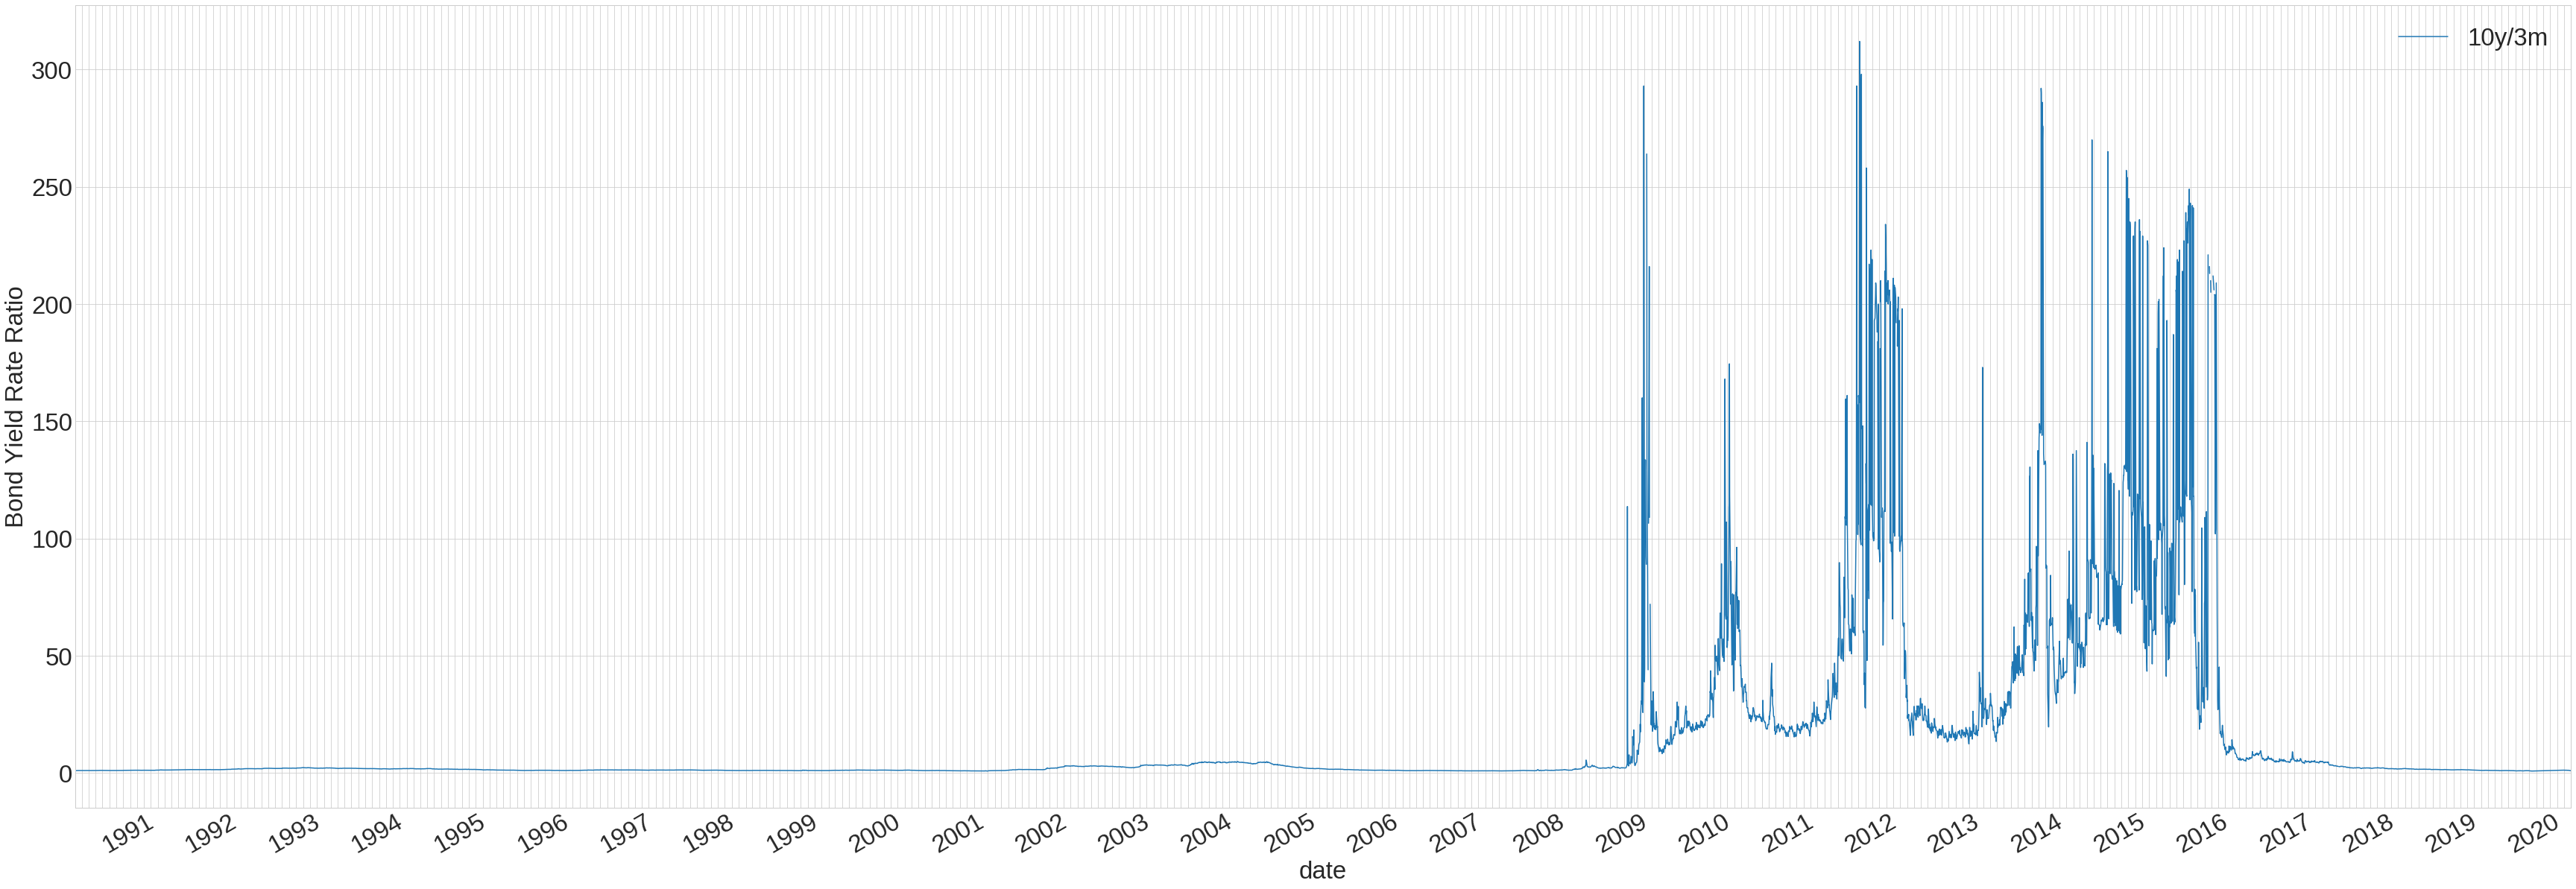

In [49]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.subplot()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.grid(which='both', axis='x')
plt.ylabel('Bond Yield Rate Ratio')
datemin = datetime.date(1990, 12, 2)
datemax = datetime.date(2019 + 0, 1, 1)
ax.set_xlim(datemin, datemax)

df.plot(kind='line', x='date', y='10y/3m', ax=ax)

plt.show()

### Bond Yield Rate Ratios For Years 2016 to 2018

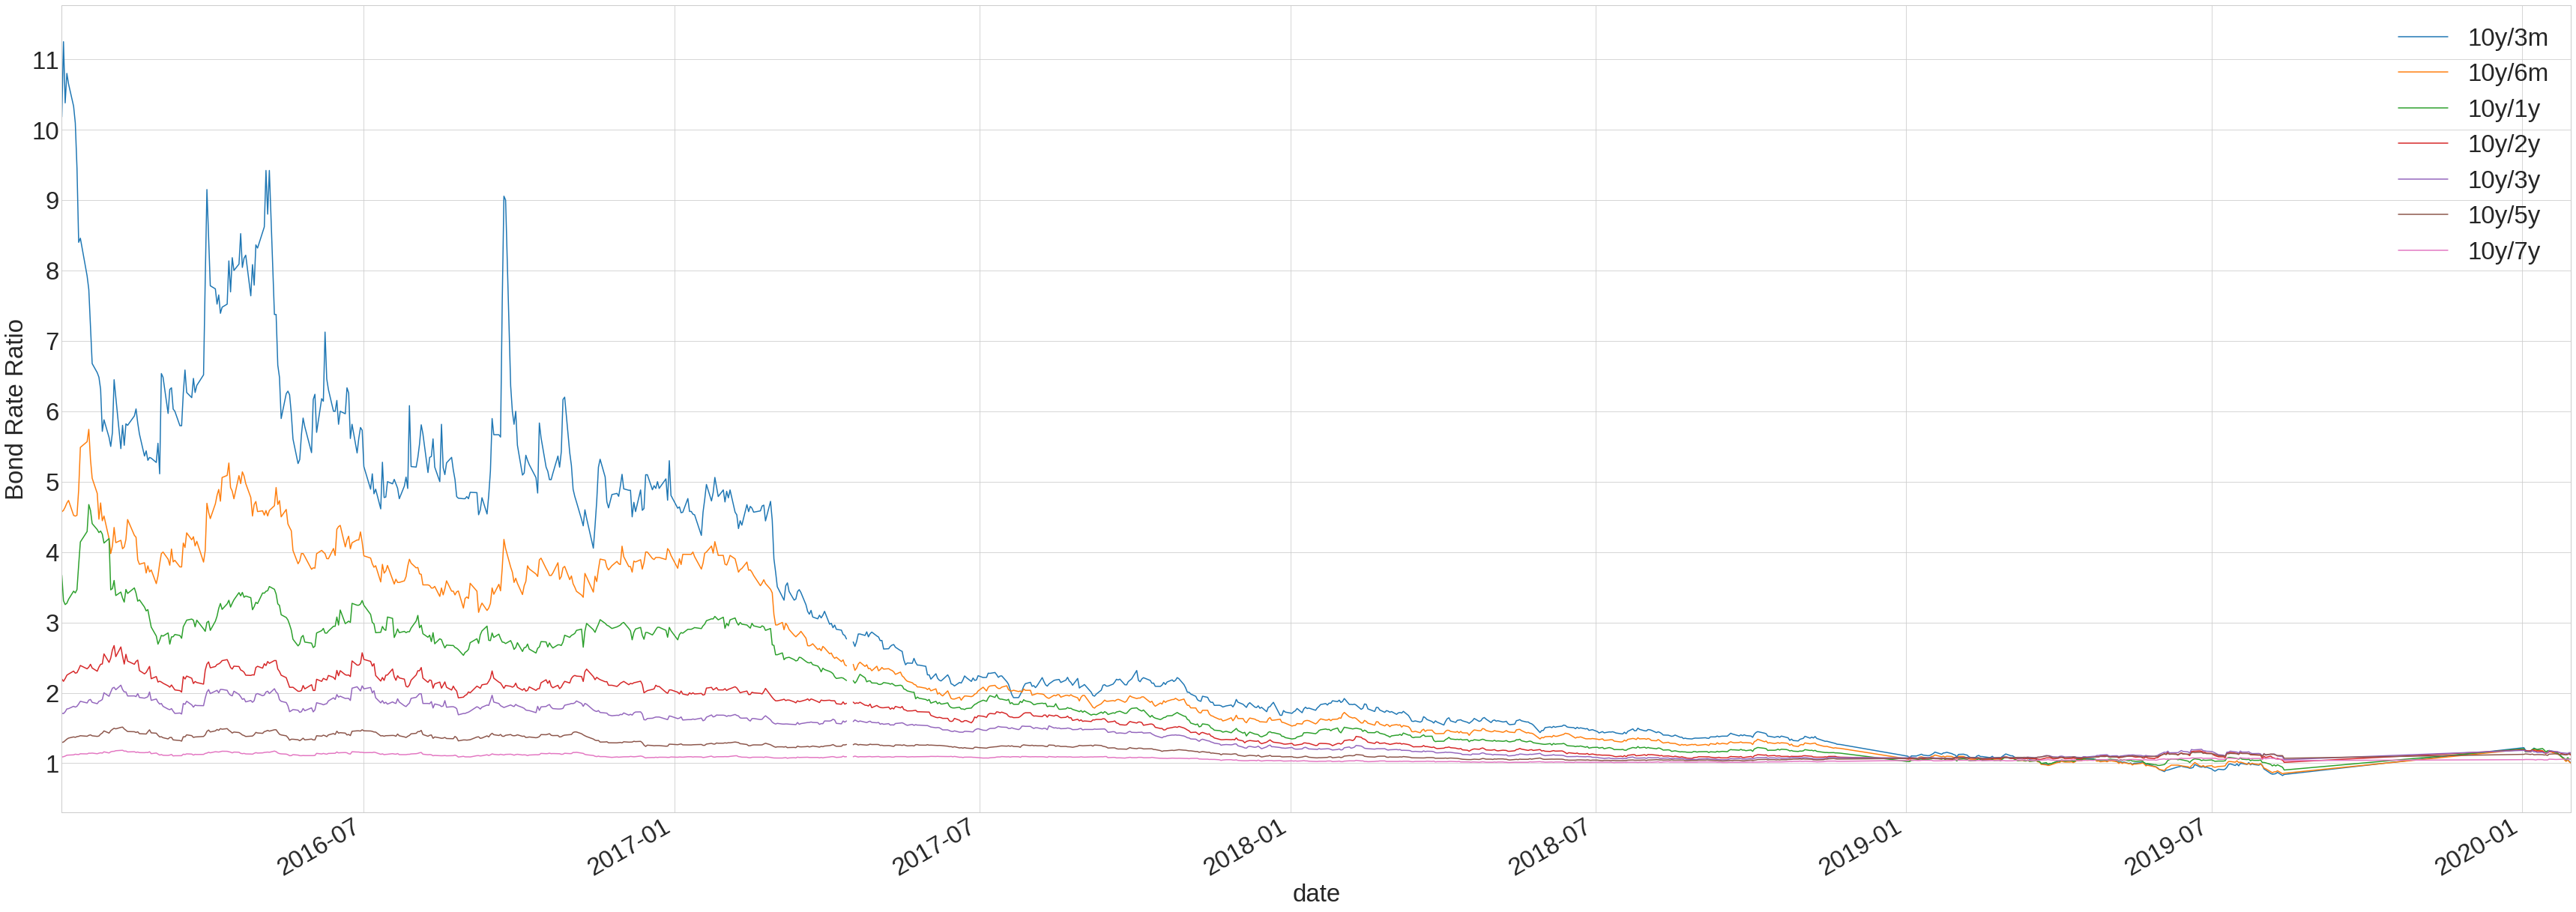

In [53]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.subplot()
plt.ylabel('Bond Rate Ratio')
plt.yticks(np.arange(0, 81, 80))

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))
df_lim_16.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Ratios for 2019 to Present

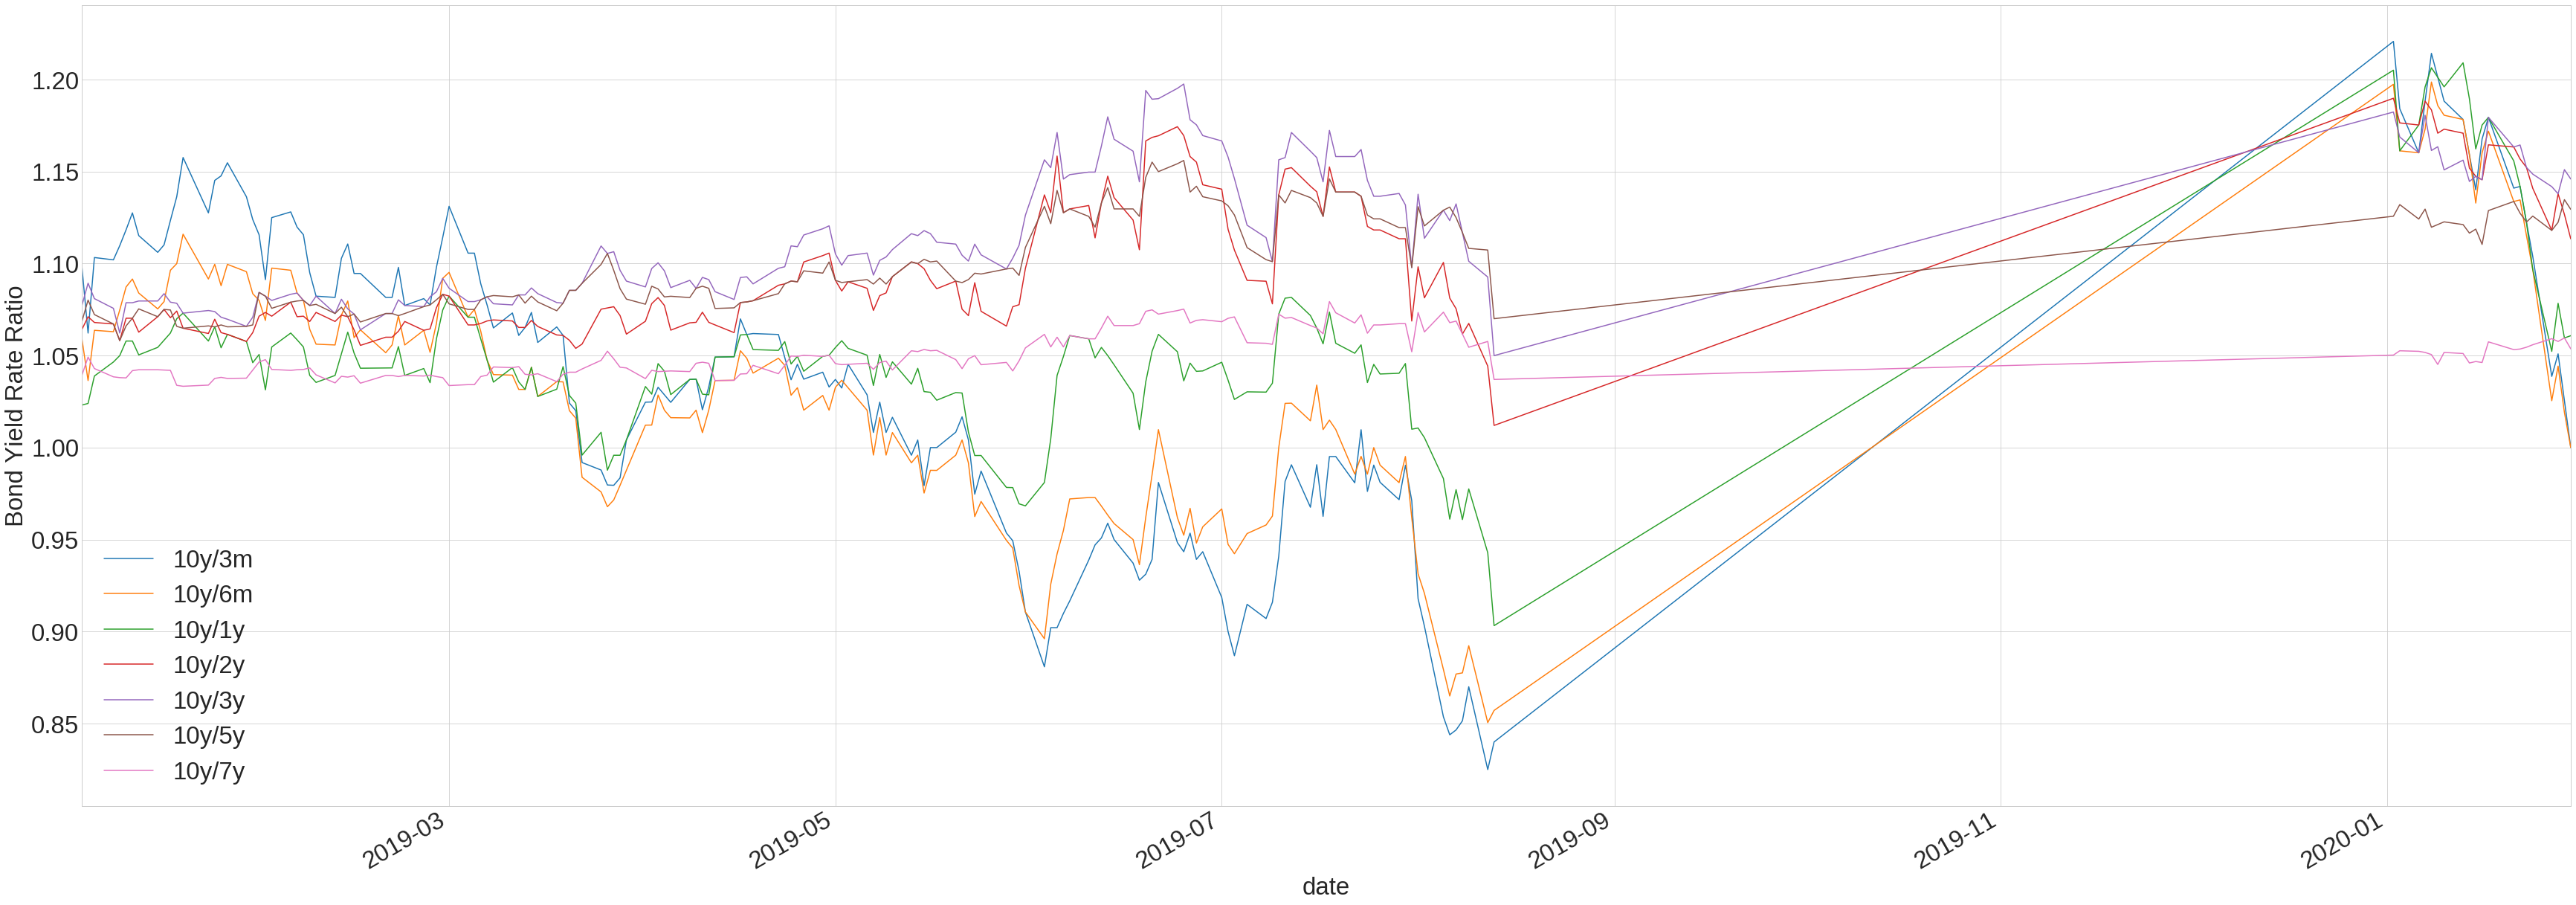

In [54]:
df_lim_18 = df
df_lim_18 = df.loc[df['date']>='2019-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_18.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate Recent Past

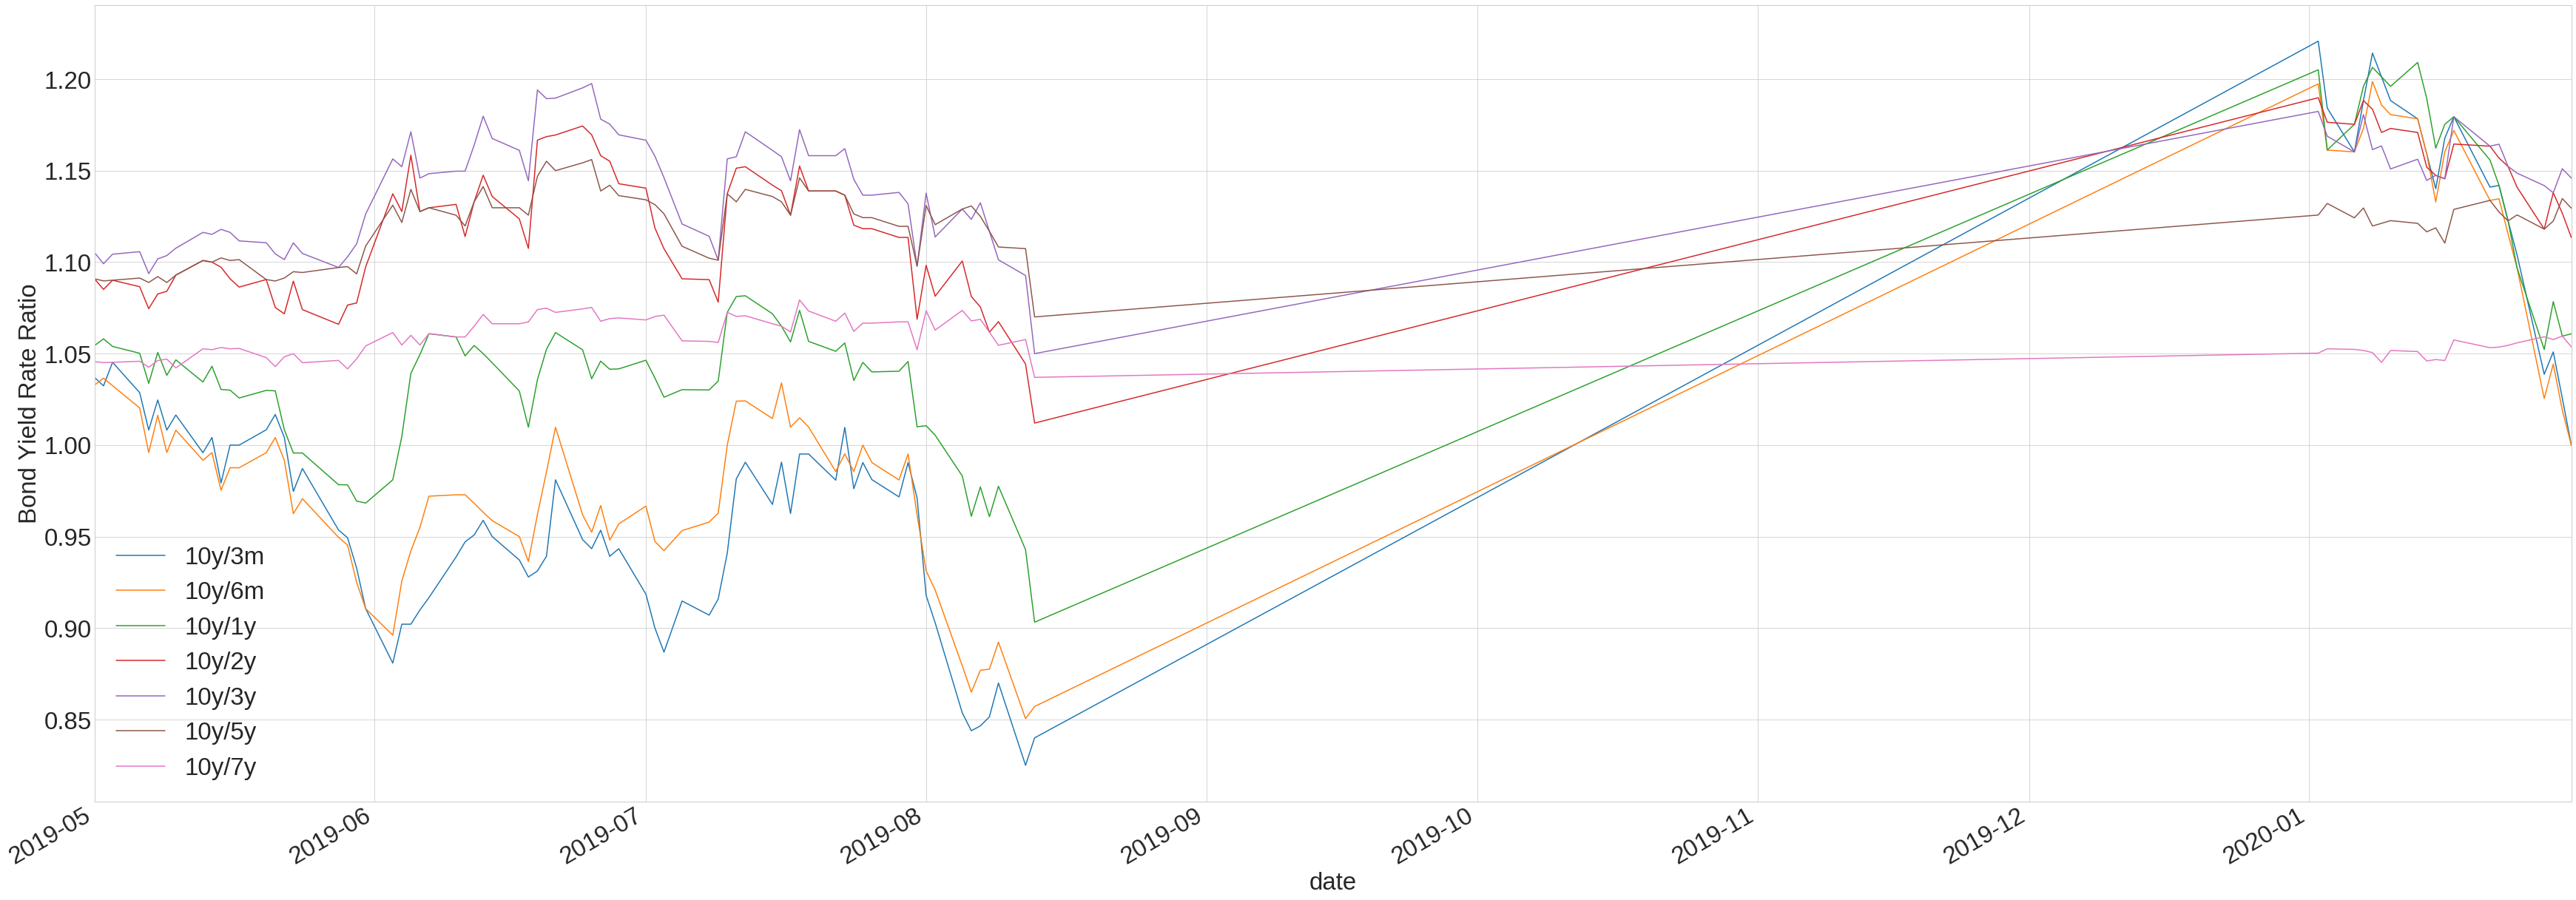

In [55]:
df_lim_19 = df
df_lim_19 = df.loc[df['date']>='2019-05-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_19.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_19.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

### Bond Yield Rate This Year

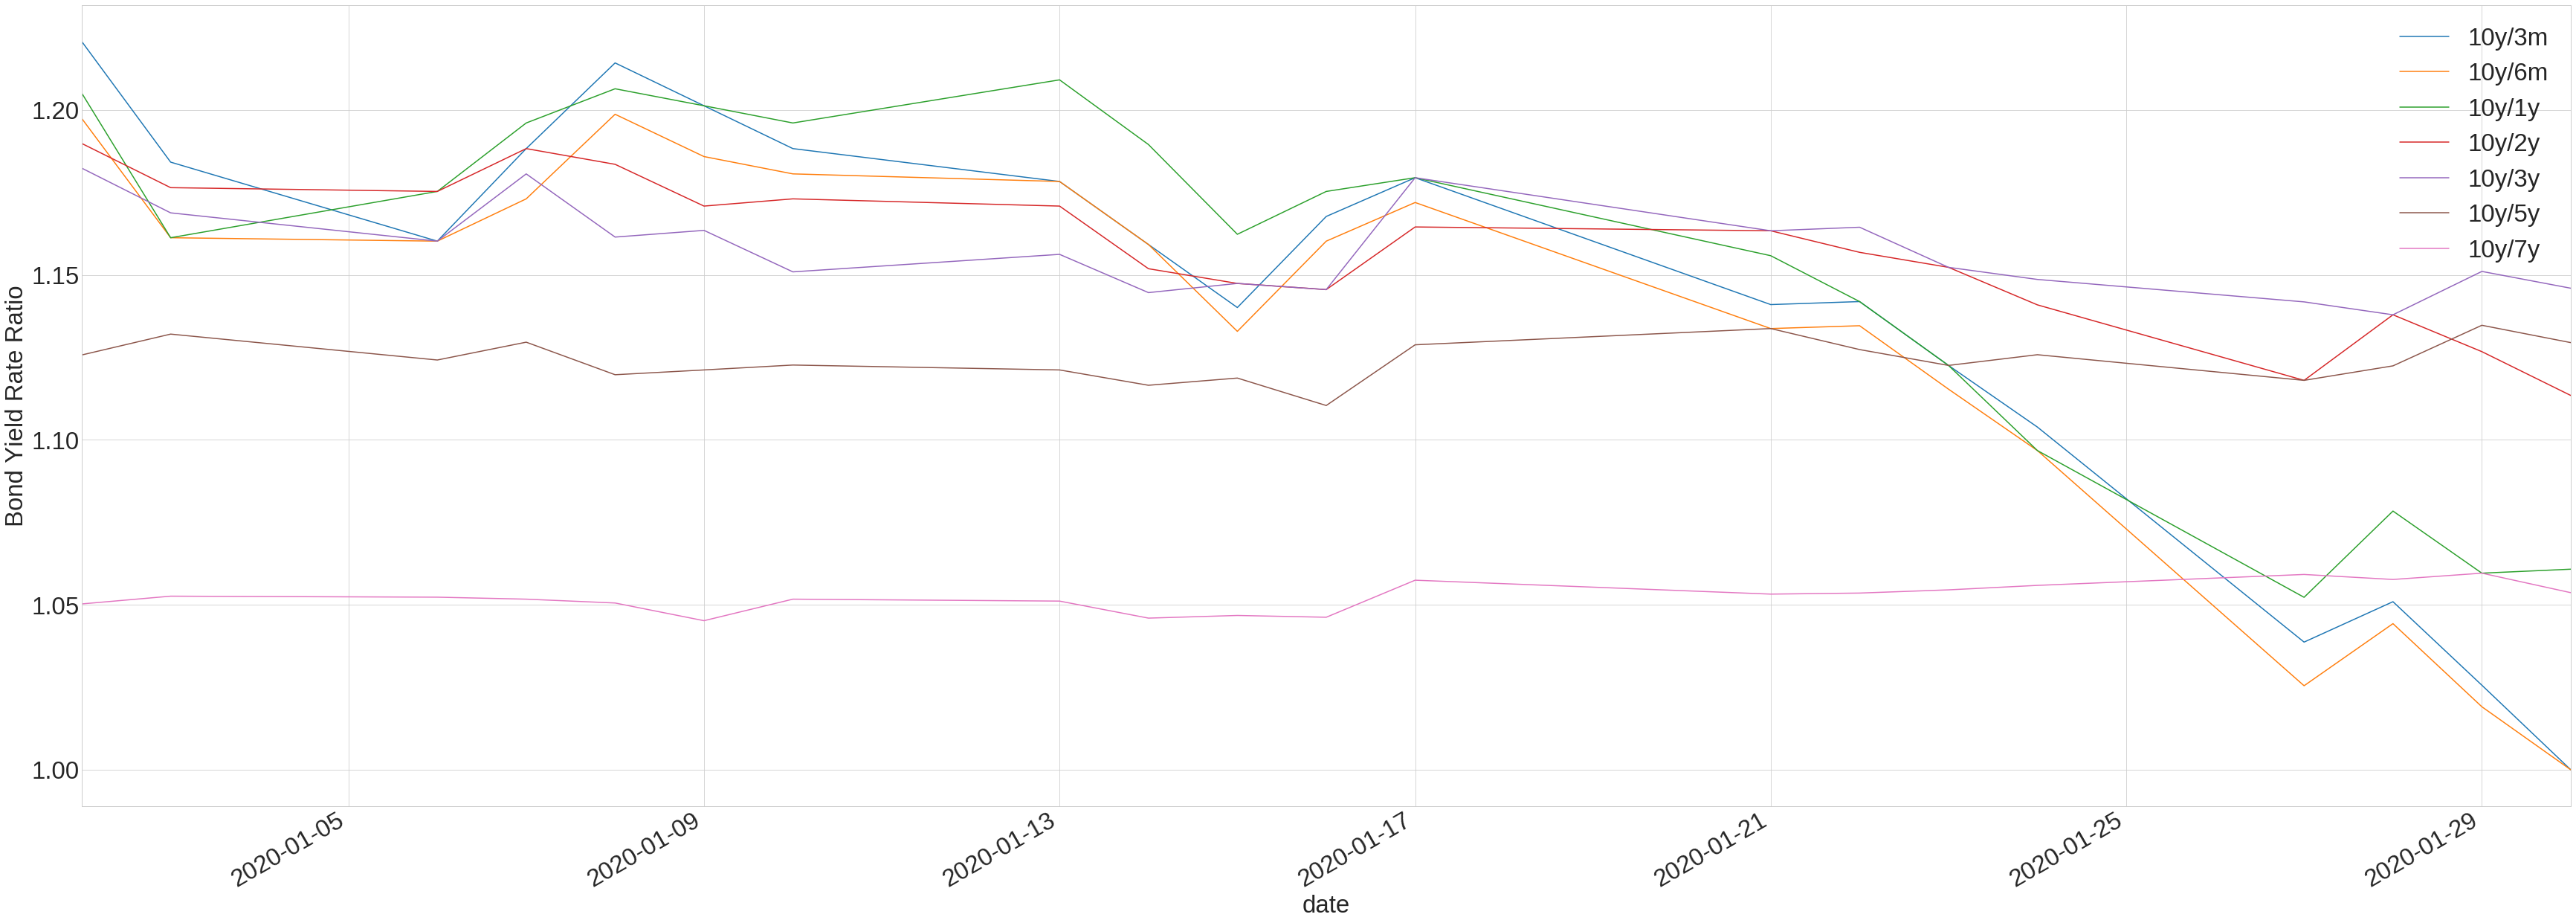

In [56]:
df_lim_20 = df
df_lim_20 = df.loc[df['date']>='2020-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_20.plot(kind='line', x='date', y='10y/3m', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/6m', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/1y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/2y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/3y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/5y', ax=ax)
df_lim_20.plot(kind='line', x='date', y='10y/7y', ax=ax)

plt.show()

In [57]:
df_lim_20.tail(10)

date    1m    3m    6m    1y    2y    3y    5y    7y   10y   30y  \
7518 2020-01-16  1.54  1.55  1.56  1.54  1.58  1.58  1.63  1.73  1.81  2.26   
7519 2020-01-17  1.54  1.56  1.57  1.56  1.58  1.56  1.63  1.74  1.84  2.29   
7520 2020-01-21  1.52  1.56  1.57  1.54  1.53  1.53  1.57  1.69  1.78  2.23   
7521 2020-01-22  1.52  1.55  1.56  1.55  1.53  1.52  1.57  1.68  1.77  2.22   
7522 2020-01-23  1.55  1.55  1.56  1.55  1.51  1.51  1.55  1.65  1.74  2.18   
7523 2020-01-24  1.54  1.54  1.55  1.55  1.49  1.48  1.51  1.61  1.70  2.14   
7524 2020-01-27  1.53  1.55  1.57  1.53  1.44  1.41  1.44  1.52  1.61  2.05   
7525 2020-01-28  1.53  1.57  1.58  1.53  1.45  1.45  1.47  1.56  1.65  2.10   
7526 2020-01-29  1.52  1.56  1.57  1.51  1.42  1.39  1.41  1.51  1.60  2.05   
7527 2020-01-30  1.59  1.57  1.57  1.48  1.41  1.37  1.39  1.49  1.57  2.04   

        10y/3m    10y/6m    10y/1y    10y/2y    10y/3y    10y/5y    10y/7y  \
7518  1.167742  1.160256  1.175325  1.145570  1.145570  1.110429  1.046243   
7519  1.179487  1.171975  1.179487  1.164557  1.179487  1.128834  1.057471   
7520  1.141026  1.133758  1.155844  1.163399  1.163399  1.133758  1.053254   
7521  1.141935  1.134615  1.141935  1.156863  1.164474  1.127389  1.053571   
7522  1.122581  1.115385  1.122581  1.152318  1.152318  1.122581  1.054545   
7523  1.103896  1.096774  1.096774  1.140940  1.148649  1.125828  1.055901   
7524  1.038710  1.025478  1.052288  1.118056  1.141844  1.118056  1.059211   
7525  1.050955  1.044304  1.078431  1.137931  1.137931  1.122449  1.057692   
7526  1.025641  1.019108  1.059603  1.126761  1.151079  1.134752  1.059603   
7527  1.000000  1.000000  1.060811  1.113475  1.145985  1.129496  1.053691   

       30y/10y  
7518  1.248619  
7519  1.244565  
7520  1.252809  
7521  1.254237  
7522  1.252874  
7523  1.258824  
7524  1.273292  
7525  1.272727  
7526  1.281250  
7527  1.299363